In [1]:
import platform
print(platform.machine())

# make sure to use python for arm64 architecture (at lease in my mac), it getting errors when using tensorflow

arm64


# MODEL 1 CH1 + CH2

Columns used: ['ch1_entropy', 'ch1_skewness', 'ch1_interquartile_range', 'ch1_kurtosis', 'ch1_percentile_75', 'ch1_range', 'ch1_maximum', 'ch1_median', 'ch1_percentile_90', 'ch1_mean_absolute_deviation', 'ch2_entropy', 'ch2_skewness', 'ch2_interquartile_range', 'ch2_kurtosis', 'ch2_percentile_75', 'ch2_range', 'ch2_maximum', 'ch2_median', 'ch2_percentile_90', 'ch2_mean_absolute_deviation']
Label counts:
 alexa_standby            714
big_lamp_small_light     743
empty                   1400
ipad_augusto             993
lightbulb_augusto       1313
mac_luca                 830
dtype: int64


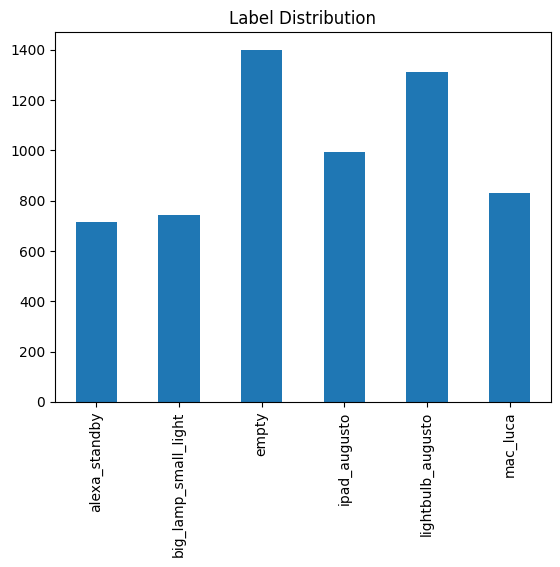

Epoch 1/50


/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - binary_accuracy: 0.8328 - loss: 0.3912 - val_binary_accuracy: 0.9791 - val_loss: 0.0749
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.9696 - loss: 0.0954 - val_binary_accuracy: 0.9910 - val_loss: 0.0354
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.9837 - loss: 0.0521 - val_binary_accuracy: 0.9932 - val_loss: 0.0221
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.9899 - loss: 0.0375 - val_binary_accuracy: 0.9954 - val_loss: 0.0159
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9934 - loss: 0.0240 - val_binary_accuracy: 0.9960 - val_loss: 0.0122
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9937 - loss: 0.0234 - val_binary_accuracy: 0.9967 - val_loss: 0.0104
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9954 - loss: 0.0164 - val_binary_accuracy: 0.9969 - val_loss: 0.0088
Epoch 8/50
150/

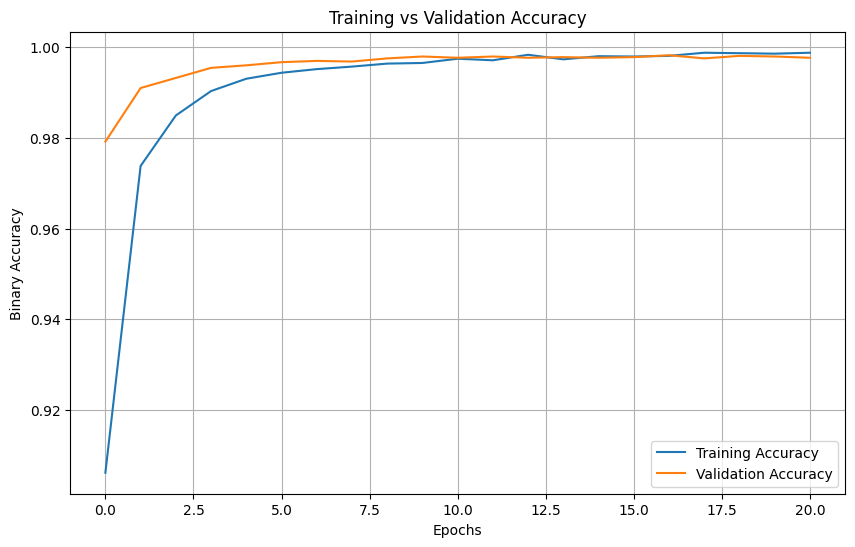

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9975 - loss: 0.0063  
Test Loss: 0.004983891732990742
Test Accuracy: 0.9977758526802063


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt

# Load and preprocess the data
file_path = 'test_11-15.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Drop unnecessary columns
X = data.drop(columns=['date', 'timestamp', 'device_label', 'session'])

# Display columns for verification
print("Columns used:", X.columns.tolist())

# Handle missing values if any
# Uncomment the following line if you want to drop rows with missing values
# X = X.dropna()

# Target variable
y = data['device_label'].str.split('|')  # Split multi-labels by the separator "|"

# Convert multi-label device labels into a binary matrix for training
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)  # y is now a binary matrix suitable for multi-label classification

# Save the MultiLabelBinarizer for future use
joblib.dump(mlb, 'mlb1.pkl')

# Check label distribution
label_counts = pd.DataFrame(y, columns=mlb.classes_).sum()
print("Label counts:\n", label_counts)
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the fitted scaler for future use
joblib.dump(scaler, 'scaler1.pkl')

# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')  # Multi-label output with sigmoid activation
])

'''
Why is validation/testing acuracy > training accuracy?
This happens when you use Dropout, since the behaviour when training and testing are different.
When training, a percentage of the features are set to zero (50% in your case since you are using 
Dropout(0.5)). When testing, all features are used (and are scaled appropriately). So the model at 
test time is more robust - and can lead to higher testing accuracies.
'''

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy()])

# Define early stopping for better performance
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

# Save the trained model
model.save('model1.h5')

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# MODEL 2 CH1 only

Columns used: ['ch1_entropy', 'ch1_skewness', 'ch1_interquartile_range', 'ch1_kurtosis', 'ch1_percentile_75', 'ch1_range', 'ch1_maximum', 'ch1_median', 'ch1_percentile_90', 'ch1_mean_absolute_deviation']
Label counts:
 alexa_standby            714
big_lamp_small_light     743
empty                   1400
ipad_augusto             993
lightbulb_augusto       1313
mac_luca                 830
dtype: int64


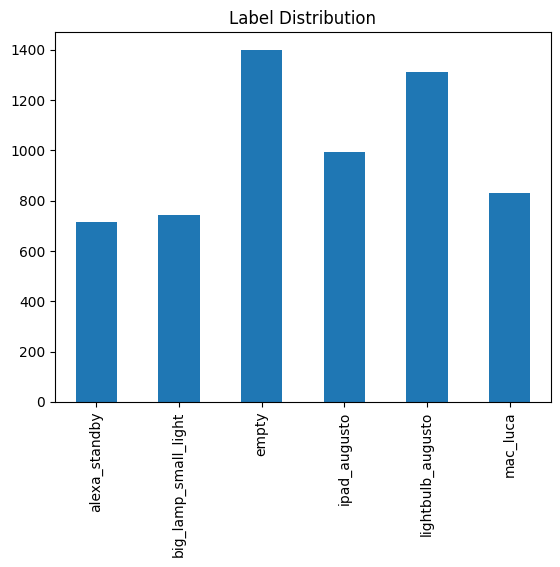

Epoch 1/50


/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - binary_accuracy: 0.8013 - loss: 0.4502 - val_binary_accuracy: 0.9558 - val_loss: 0.1468
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9435 - loss: 0.1650 - val_binary_accuracy: 0.9678 - val_loss: 0.0995
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9616 - loss: 0.1123 - val_binary_accuracy: 0.9744 - val_loss: 0.0793
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9676 - loss: 0.0949 - val_binary_accuracy: 0.9789 - val_loss: 0.0682
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9704 - loss: 0.0825 - val_binary_accuracy: 0.9800 - val_loss: 0.0618
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9740 - loss: 0.0754 - val_binary_accuracy: 0.9828 - val_loss: 0.0541
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9747 - loss: 0.0686 - val_binary_accuracy: 0.9835 - val_loss: 0.0508
Epoch 8/50
150/1

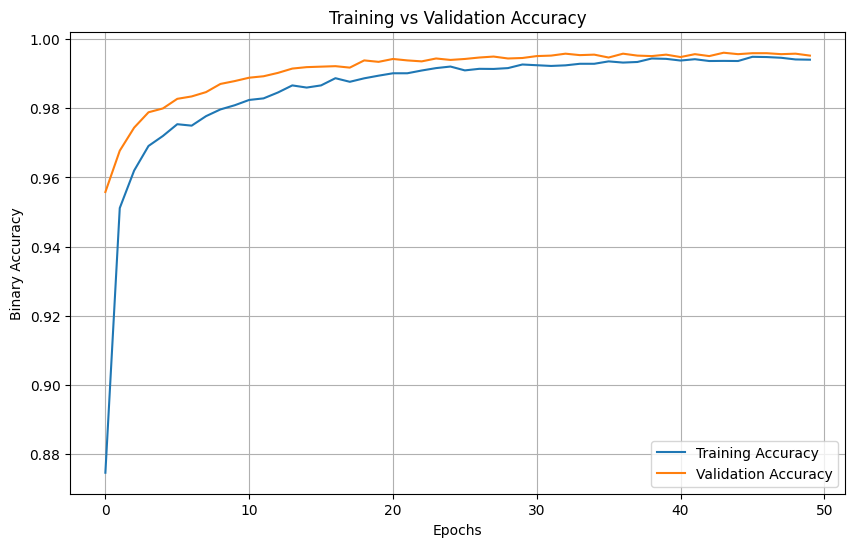

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9954 - loss: 0.0260
Test Loss: 0.017173882573843002
Test Accuracy: 0.9958297610282898


In [5]:
# Load and preprocess the data
file_path = 'test_11-15.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Drop unnecessary columns
X = data.drop(columns=['date', 'timestamp', 'device_label', 'session', 'ch2_entropy', 'ch2_skewness', 'ch2_interquartile_range', 'ch2_kurtosis', 'ch2_percentile_75', 'ch2_range', 'ch2_maximum', 'ch2_median', 'ch2_percentile_90', 'ch2_mean_absolute_deviation'])

# Display columns for verification
print("Columns used:", X.columns.tolist())

# Handle missing values if any
# Uncomment the following line if you want to drop rows with missing values
# X = X.dropna()

# Target variable
y = data['device_label'].str.split('|')  # Split multi-labels by the separator "|"

# Convert multi-label device labels into a binary matrix for training
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)  # y is now a binary matrix suitable for multi-label classification

# Save the MultiLabelBinarizer for future use
joblib.dump(mlb, 'mlb2.pkl')

# Check label distribution
label_counts = pd.DataFrame(y, columns=mlb.classes_).sum()
print("Label counts:\n", label_counts)
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the fitted scaler for future use
joblib.dump(scaler, 'scaler2.pkl')

# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')  # Multi-label output with sigmoid activation
])

'''
Why is validation/testing acuracy > training accuracy?
This happens when you use Dropout, since the behaviour when training and testing are different.
When training, a percentage of the features are set to zero (50% in your case since you are using 
Dropout(0.5)). When testing, all features are used (and are scaled appropriately). So the model at 
test time is more robust - and can lead to higher testing accuracies.
'''

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy()])

# Define early stopping for better performance
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

# Save the trained model
model.save('model2.h5')

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# MODEL 2 CH2 only

Columns used: ['ch2_entropy', 'ch2_skewness', 'ch2_interquartile_range', 'ch2_kurtosis', 'ch2_percentile_75', 'ch2_range', 'ch2_maximum', 'ch2_median', 'ch2_percentile_90', 'ch2_mean_absolute_deviation']
Label counts:
 alexa_standby            714
big_lamp_small_light     743
empty                   1400
ipad_augusto             993
lightbulb_augusto       1313
mac_luca                 830
dtype: int64


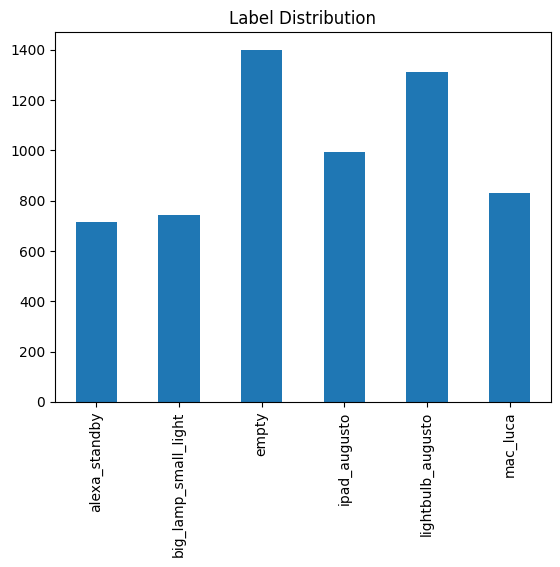

Epoch 1/50


/Users/augustochang/miniforge3/envs/tester_arm/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - binary_accuracy: 0.7660 - loss: 0.4764 - val_binary_accuracy: 0.9412 - val_loss: 0.1752
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9305 - loss: 0.1856 - val_binary_accuracy: 0.9704 - val_loss: 0.1014
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9580 - loss: 0.1249 - val_binary_accuracy: 0.9826 - val_loss: 0.0647
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9683 - loss: 0.0939 - val_binary_accuracy: 0.9879 - val_loss: 0.0477
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9764 - loss: 0.0731 - val_binary_accuracy: 0.9880 - val_loss: 0.0430
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9787 - loss: 0.0599 - val_binary_accuracy: 0.9896 - val_loss: 0.0357
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9822 - loss: 0.0586 - val_binary_accuracy: 0.9899 - val_loss: 0.0310
Epoch 8/50
150/1

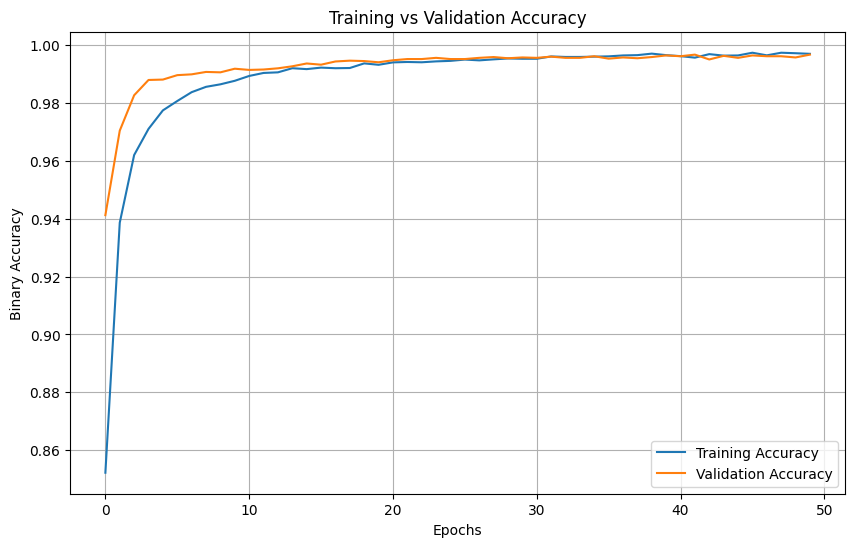

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9974 - loss: 0.0143
Test Loss: 0.011090024374425411
Test Accuracy: 0.9966639876365662


In [6]:
# Load and preprocess the data
file_path = 'test_11-15.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Drop unnecessary columns
X = data.drop(columns=['date', 'timestamp', 'device_label', 'session', 'ch1_entropy', 'ch1_skewness', 'ch1_interquartile_range', 'ch1_kurtosis', 'ch1_percentile_75', 'ch1_range', 'ch1_maximum', 'ch1_median', 'ch1_percentile_90', 'ch1_mean_absolute_deviation'])

# Display columns for verification
print("Columns used:", X.columns.tolist())

# Handle missing values if any
# Uncomment the following line if you want to drop rows with missing values
# X = X.dropna()

# Target variable
y = data['device_label'].str.split('|')  # Split multi-labels by the separator "|"

# Convert multi-label device labels into a binary matrix for training
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)  # y is now a binary matrix suitable for multi-label classification

# Save the MultiLabelBinarizer for future use
joblib.dump(mlb, 'mlb3.pkl')

# Check label distribution
label_counts = pd.DataFrame(y, columns=mlb.classes_).sum()
print("Label counts:\n", label_counts)
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the fitted scaler for future use
joblib.dump(scaler, 'scaler3.pkl')

# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')  # Multi-label output with sigmoid activation
])

'''
Why is validation/testing acuracy > training accuracy?
This happens when you use Dropout, since the behaviour when training and testing are different.
When training, a percentage of the features are set to zero (50% in your case since you are using 
Dropout(0.5)). When testing, all features are used (and are scaled appropriately). So the model at 
test time is more robust - and can lead to higher testing accuracies.
'''

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy()])

# Define early stopping for better performance
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

# Save the trained model
model.save('model3.h5')

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# MODEL 4 CH1 only - no light bulb


Columns used: ['ch1_entropy', 'ch1_skewness', 'ch1_interquartile_range', 'ch1_kurtosis', 'ch1_percentile_75', 'ch1_range', 'ch1_maximum', 'ch1_median', 'ch1_percentile_90', 'ch1_mean_absolute_deviation']
Label counts:
 big_lamp_small_light     743
empty                   1400
ipad_augusto            2183
mac_luca                2020
dtype: int64


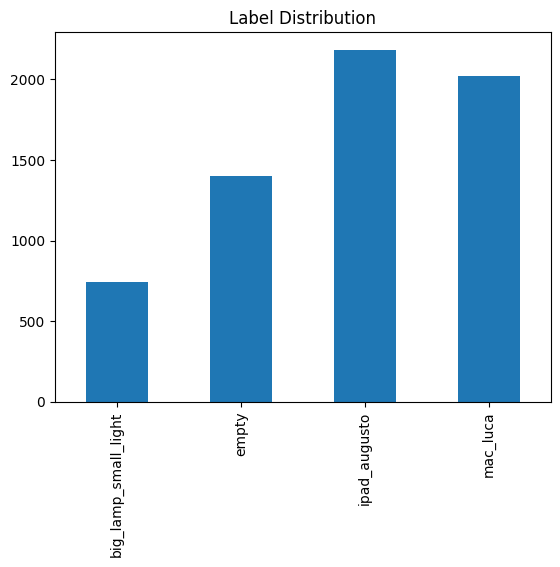

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8063 - loss: 0.4573 - val_binary_accuracy: 0.9736 - val_loss: 0.1065
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9701 - loss: 0.1122 - val_binary_accuracy: 0.9840 - val_loss: 0.0555
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9803 - loss: 0.0678 - val_binary_accuracy: 0.9884 - val_loss: 0.0383
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9854 - loss: 0.0478 - val_binary_accuracy: 0.9884 - val_loss: 0.0313
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9881 - loss: 0.0380 - val_binary_accuracy: 0.9901 - val_loss: 0.0278
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9889 - loss: 0.0338 - val_binary_accuracy: 0.9889 - val_loss: 0.0272
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9898 - loss: 0.0319 - val_binary_accuracy: 0.9898 - val_loss: 0.0250
Epoch

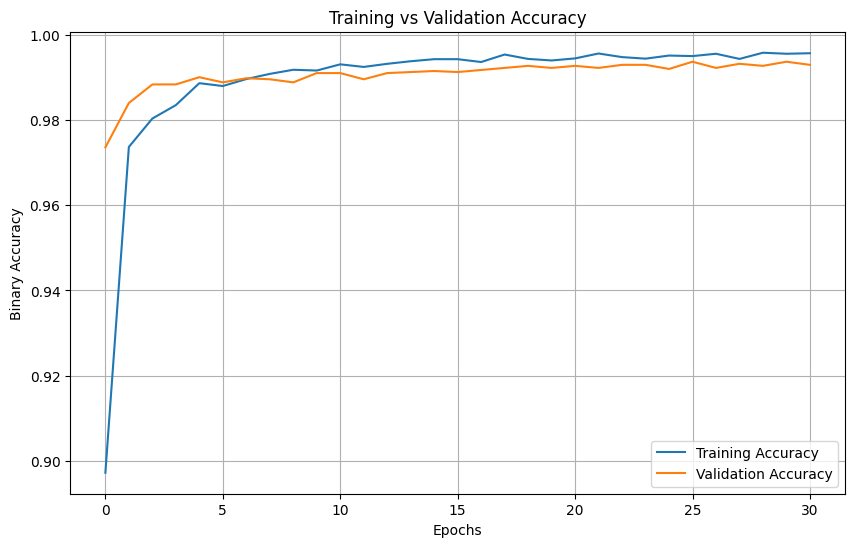

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9927 - loss: 0.0182
Test Loss: 0.016227617859840393
Test Accuracy: 0.9937015771865845
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
                       precision    recall  f1-score   support

big_lamp_small_light       1.00      0.99      0.99       146
               empty       0.99      1.00      0.99       289
        ipad_augusto       0.98      0.98      0.98       433
            mac_luca       0.99      1.00      1.00       419

           micro avg       0.99      0.99      0.99      1287
           macro avg       0.99      0.99      0.99      1287
        weighted avg       0.99      0.99      0.99      1287
         samples avg       0.99      0.99      0.99      1287

Confusion matrix for big_lamp_small_light:
TN: 886, FP: 0, FN: 2, TP: 144
Per-Class Accuracy: 0.9981

Confusion matrix for empty:
TN: 740, FP: 3, FN: 1, TP: 288
Per-Class Accuracy: 0.9961

Confusion matrix for ipad_augusto:
TN: 59

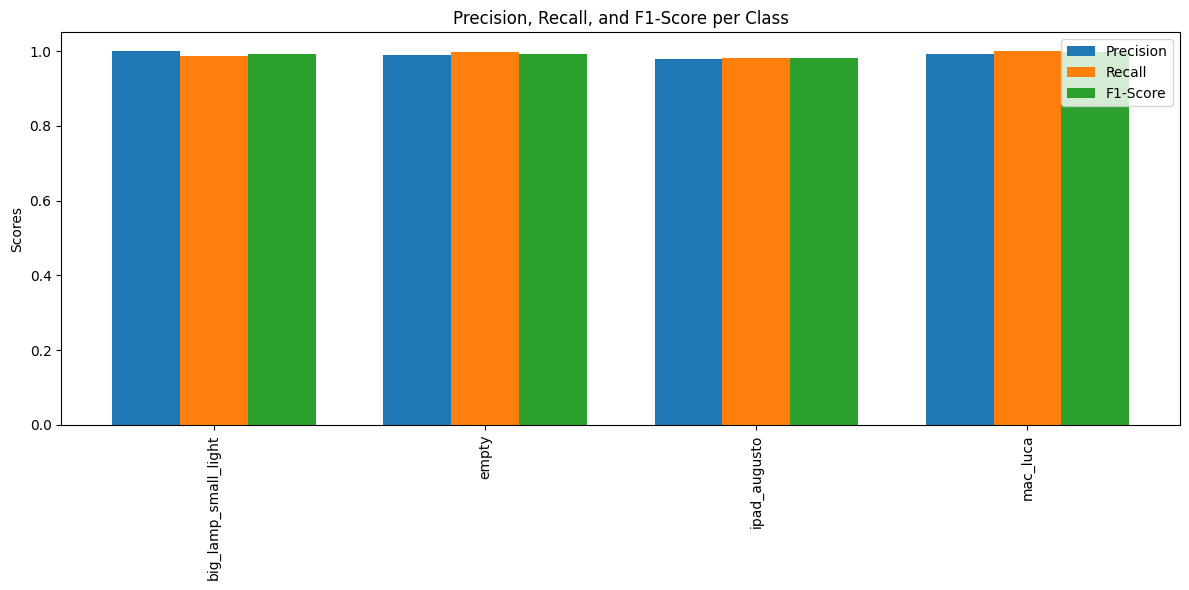

Macro Precision: 0.9905
Macro Recall: 0.9911
Macro F1-Score: 0.9908

Micro Precision: 0.9884
Micro Recall: 0.9915
Micro F1-Score: 0.9899


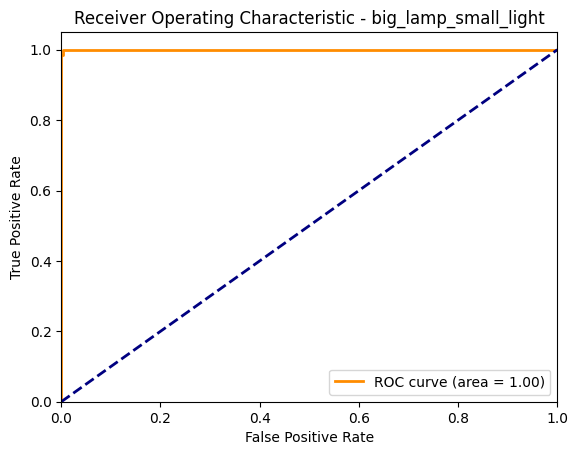

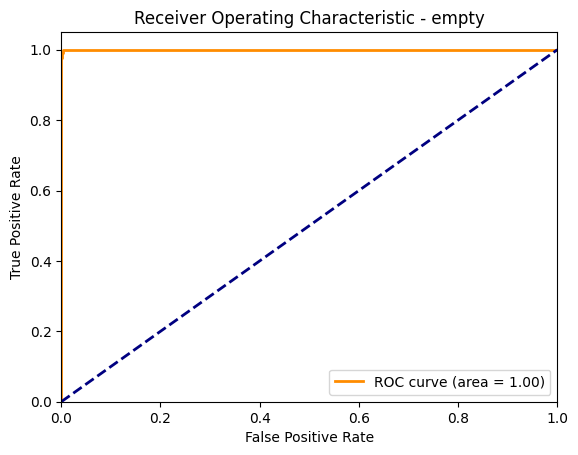

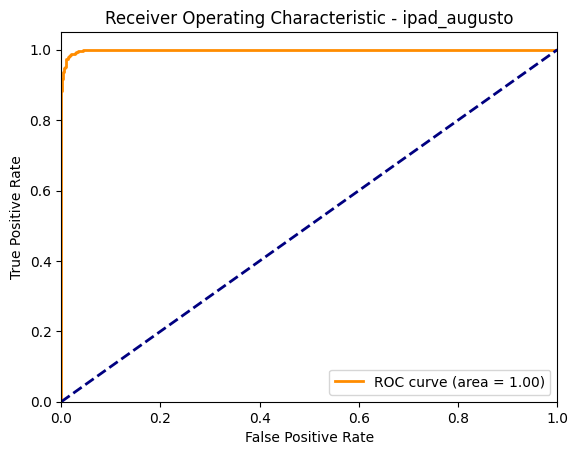

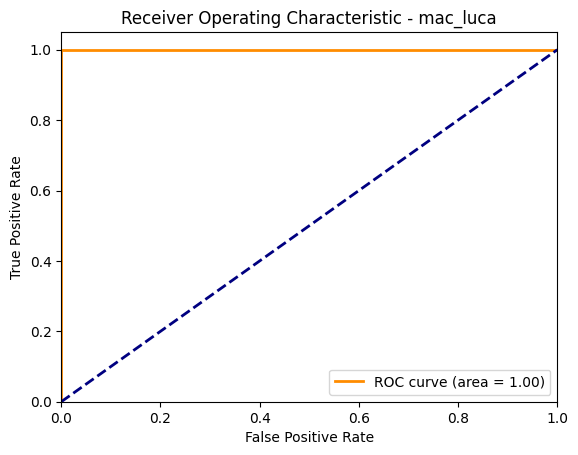

Optimal threshold for big_lamp_small_light is 0.9993
Optimal threshold for empty is 0.1744
Optimal threshold for ipad_augusto is 0.3976
Optimal threshold for mac_luca is 0.8492
Classification Report with Optimal Thresholds:
                       precision    recall  f1-score   support

big_lamp_small_light       1.00      0.99      0.99       146
               empty       0.99      1.00      0.99       289
        ipad_augusto       0.97      0.99      0.98       433
            mac_luca       1.00      1.00      1.00       419

           micro avg       0.99      0.99      0.99      1287
           macro avg       0.99      0.99      0.99      1287
        weighted avg       0.99      0.99      0.99      1287
         samples avg       0.99      0.99      0.99      1287



In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import (
    classification_report,
    multilabel_confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve
)
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess the data
file_path = 'test_11-15_welch.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Drop unnecessary columns
# X = data.drop(columns=['date', 'timestamp', 'device_label', 'session'])

X = data.drop(columns=['date', 'timestamp', 'device_label', 'session', 'ch2_entropy', 'ch2_skewness', 'ch2_interquartile_range', 'ch2_kurtosis', 'ch2_percentile_75', 'ch2_range', 'ch2_maximum', 'ch2_median', 'ch2_percentile_90', 'ch2_mean_absolute_deviation'])

# Display columns for verification
print("Columns used:", X.columns.tolist())

# Handle missing values if any
# Uncomment the following line if you want to drop rows with missing values
# X = X.dropna()

# Target variable
y = data['device_label'].str.split('|')  # Split multi-labels by the separator "|"

# Convert multi-label device labels into a binary matrix for training
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)  # y is now a binary matrix suitable for multi-label classification

# Save the MultiLabelBinarizer for future use
joblib.dump(mlb, 'mlb_welch_nn.pkl')

# Check label distribution
label_counts = pd.DataFrame(y, columns=mlb.classes_).sum()
print("Label counts:\n", label_counts)
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the fitted scaler for future use
joblib.dump(scaler, 'scaler_welch_nn.pkl')

# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')  # Multi-label output with sigmoid activation
])

'''
Why is validation/testing accuracy > training accuracy?
This happens when you use Dropout, since the behaviour when training and testing are different.
When training, a percentage of the features are set to zero (30% in your case since you are using 
Dropout(0.3)). When testing, all features are used (and are scaled appropriately). So the model at 
test time is more robust - and can lead to higher testing accuracies.
'''

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy()])

# Define early stopping for better performance
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

# Save the trained model
model.save('model_welch_nn.h5')

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities on the test set
y_pred_prob = model.predict(X_test_scaled)

# Apply a threshold to get binary predictions (you can adjust the threshold as needed)
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=mlb.classes_)
print("Classification Report:\n", report)

# Compute confusion matrices for each label
confusion_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Display confusion matrices and per-class accuracy
per_class_accuracy = {}
for idx, label in enumerate(mlb.classes_):
    cm = confusion_matrices[idx]
    tn, fp, fn, tp = cm.ravel()
    per_class_acc = (tp + tn) / (tp + tn + fp + fn)
    per_class_accuracy[label] = per_class_acc
    print(f"Confusion matrix for {label}:")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Per-Class Accuracy: {per_class_acc:.4f}\n")

# Compute overall accuracy (exact match ratio)
subset_acc = accuracy_score(y_test, y_pred)
print(f"Subset Accuracy (Exact Match Ratio): {subset_acc:.4f}")

# Get precision, recall, and F1-score for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, zero_division=0)

# Plot precision, recall, and F1-score per class
x = np.arange(len(mlb.classes_))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(mlb.classes_, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# Compute macro and micro averages
macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

micro_precision = precision_score(y_test, y_pred, average='micro', zero_division=0)
micro_recall = recall_score(y_test, y_pred, average='micro', zero_division=0)
micro_f1 = f1_score(y_test, y_pred, average='micro', zero_division=0)

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}\n")

print(f"Micro Precision: {micro_precision:.4f}")
print(f"Micro Recall: {micro_recall:.4f}")
print(f"Micro F1-Score: {micro_f1:.4f}")

# Compute ROC curve and ROC area for each class
for idx, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_test[:, idx], y_pred_prob[:, idx])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {label}')
    plt.legend(loc="lower right")
    plt.show()

# Function to find optimal threshold per class
optimal_thresholds = []
for idx in range(y_test.shape[1]):
    precision_c, recall_c, thresholds = precision_recall_curve(y_test[:, idx], y_pred_prob[:, idx])
    fscore = 2 * (precision_c * recall_c) / (precision_c + recall_c + 1e-8)
    ix = np.argmax(fscore)
    optimal_thresh = thresholds[ix] if ix < len(thresholds) else 0.5  # Handle edge cases
    optimal_thresholds.append(optimal_thresh)
    print(f'Optimal threshold for {mlb.classes_[idx]} is {optimal_thresh:.4f}')

# Apply optimal thresholds
y_pred_optimal = np.zeros_like(y_pred_prob)
for idx, thresh in enumerate(optimal_thresholds):
    y_pred_optimal[:, idx] = (y_pred_prob[:, idx] >= thresh).astype(int)

# Recompute metrics with optimal thresholds
report_optimal = classification_report(y_test, y_pred_optimal, target_names=mlb.classes_)
print("Classification Report with Optimal Thresholds:\n", report_optimal)


# PIVOT TABLE TEST

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# For multi-label classification with scikit-learn models
from sklearn.multiclass import OneVsRestClassifier

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 1. Define File Paths for Preprocessed Data
datasets = {
    'FFT': 'test_11-15_fft.csv',
    'Welch': 'test_11-15_welch.csv',
    'Histogram': 'test_11-15_histogram.csv'
}

# 2. Initialize Results DataFrame
results = pd.DataFrame(columns=['Preprocessing', 'Model', 'Subset Accuracy', 'Macro F1-Score', 'Micro F1-Score'])

# 3. Define Models
def build_neural_network(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_dim, activation='sigmoid')  # Multi-label output with sigmoid activation
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[])
    return model

models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf', probability=True),
    'Neural Network': None  # Placeholder, will build later
}

# 4. Iterate Over Datasets and Models
for preprocessing_method, file_path in datasets.items():
    print(f"\nProcessing dataset: {preprocessing_method}")
    
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Drop unnecessary columns
    X = data.drop(columns=['date', 'timestamp', 'device_label', 'session'])
    
    # Handle missing values if any
    # X = X.dropna()
    
    # Target variable
    y = data['device_label'].str.split('|')  # Split multi-labels by the separator "|"
    
    # Convert multi-label device labels into a binary matrix for training
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Update Neural Network model with correct input and output dimensions
    models['Neural Network'] = build_neural_network(input_dim=X_train_scaled.shape[1], output_dim=y_train.shape[1])
    
    for model_name, model in models.items():
        print(f"Training model: {model_name}")
        
        if model_name in ['KNN', 'SVM']:
            # Wrap the model for multi-label classification
            classifier = OneVsRestClassifier(model)
            # Fit the model
            classifier.fit(X_train_scaled, y_train)
            # Predict probabilities
            y_pred_prob = classifier.predict_proba(X_test_scaled)
            # Apply threshold
            y_pred = (y_pred_prob >= 0.5).astype(int)
        else:
            # Neural Network
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(
                X_train_scaled, y_train,
                validation_data=(X_test_scaled, y_test),
                epochs=50,
                batch_size=32,
                callbacks=[early_stopping],
                verbose=0  # Suppress training output
            )
            # Predict probabilities
            y_pred_prob = model.predict(X_test_scaled)
            # Apply threshold
            y_pred = (y_pred_prob >= 0.5).astype(int)
        
        # Evaluate the model
        subset_acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        macro_f1 = report['macro avg']['f1-score']
        micro_f1 = report['micro avg']['f1-score']
        
        # Record results
        new_row = pd.DataFrame([{
            'Preprocessing': preprocessing_method,
            'Model': model_name,
            'Subset Accuracy': subset_acc,
            'Macro F1-Score': macro_f1,
            'Micro F1-Score': micro_f1
        }])

        results = pd.concat([results, new_row], ignore_index=True)

        
        print(f"Results for {preprocessing_method} with {model_name}:")
        print(f"Subset Accuracy: {subset_acc:.4f}")
        print(f"Macro F1-Score: {macro_f1:.4f}")
        print(f"Micro F1-Score: {micro_f1:.4f}\n")

# 5. Display Results Table
print("\nFinal Results:")
print(results.pivot(index='Preprocessing', columns='Model', values=['Subset Accuracy', 'Macro F1-Score', 'Micro F1-Score']))



Processing dataset: FFT


2024-11-19 23:10:59.748783: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-11-19 23:10:59.748805: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-11-19 23:10:59.748809: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-11-19 23:10:59.749137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-19 23:10:59.749150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training model: KNN
Results for FFT with KNN:
Subset Accuracy: 0.9049
Macro F1-Score: 0.9203
Micro F1-Score: 0.9160

Training model: SVM
Results for FFT with SVM:
Subset Accuracy: 0.9299
Macro F1-Score: 0.9617
Micro F1-Score: 0.9578

Training model: Neural Network


2024-11-19 23:11:02.692818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for FFT with Neural Network:
Subset Accuracy: 0.9867
Macro F1-Score: 0.9895
Micro F1-Score: 0.9887


Processing dataset: Welch
Training model: KNN
Results for Welch with KNN:
Subset Accuracy: 0.9867
Macro F1-Score: 0.9903
Micro F1-Score: 0.9875

Training model: SVM
Results for Welch with SVM:
Subset Accuracy: 0.9883
Macro F1-Score: 0.9941
Micro F1-Score: 0.9921

Training model: Neural Network
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for Welch with Neural Network:
Subset Accuracy: 0.9933
Macro F1-Score: 0.9961
Micro F1-Score: 0.9954


Processing dataset: Histogram
Training model: KNN
Results for Histogram with KNN:
Subset Accuracy: 0.9825
Macro F1-Score: 0.9862
Micro F1-Score: 0.9849

Training model: SVM
Results for Histogram with SVM:
Subset Accuracy: 0.9716
Macro F1-Score: 0.9794
Micro F1-Score: 0.9787

Training model: Neural Network
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for Histogram with Neural Network:
Subset Accuracy: 0

In [11]:
def predict_labels(input_data):
    """
    Takes a dictionary with 'timestamp' and 'features', uses the trained model to predict labels and their probabilities.
    
    Parameters:
    input_data (dict): A dictionary containing 'timestamp' and 'features' keys.
        - 'features' should be a dictionary containing the feature names and their corresponding values.
    
    Returns:
    tuple: A tuple containing:
        - predicted_labels (list): A list of predicted labels.
        - label_probabilities (dict): A dictionary mapping label names to their predicted probabilities.
    """
    import numpy as np
    import pandas as pd
    from tensorflow.keras.models import load_model
    import joblib

    # Load the saved model, scaler, and mlb
    model = load_model('model.h5')
    scaler = joblib.load('scaler.pkl')
    mlb = joblib.load('mlb.pkl')

    # Extract features from input_data
    features = input_data.get('features')
    if features is None:
        raise ValueError("Input data must contain 'features' key.")

    # Define the feature columns (should match the columns used during training)
    feature_columns = ['ch1_entropy', 'ch1_skewness', 'ch1_interquartile_range',
                       'ch1_kurtosis', 'ch1_percentile_75', 'ch1_range', 'ch1_maximum',
                       'ch1_median', 'ch1_percentile_90', 'ch1_mean_absolute_deviation',
                       'ch2_entropy', 'ch2_skewness', 'ch2_interquartile_range', 'ch2_kurtosis',
                       'ch2_percentile_75', 'ch2_range', 'ch2_maximum', 'ch2_median',
                       'ch2_percentile_90', 'ch2_mean_absolute_deviation']

    # Ensure all required features are provided
    missing_features = set(feature_columns) - set(features.keys())
    if missing_features:
        raise ValueError(f"The following features are missing: {missing_features}")

    # Create a DataFrame with the feature columns
    X = pd.DataFrame([features], columns=feature_columns)

    # Standardize the features
    X_scaled = scaler.transform(X)

    # Make predictions
    probabilities = model.predict(X_scaled)[0]

    # Apply threshold to get binary predictions
    threshold = 0.5
    predictions_binary = (probabilities >= threshold).astype(int)

    # Ensure predictions_binary is 2D
    predictions_binary = predictions_binary.reshape(1, -1)

    # Get the predicted labels
    predicted_labels = mlb.inverse_transform(predictions_binary)[0]

    # Map label names to probabilities
    label_probabilities = dict(zip(mlb.classes_, probabilities))

    return predicted_labels, label_probabilities


In [12]:
input_data = {
    "timestamp": "2024-11-16T11:21:42.984295",
    "features": {
        "ch1_entropy": 6.055838550421127,
        "ch1_skewness": 1.6854847856978579,
        "ch1_interquartile_range": 12.499051187863515,
        "ch1_kurtosis": 3.8142032201666742,
        "ch1_percentile_75": -91.11004192373038,
        "ch1_range": 58.396163442199935,
        "ch1_maximum": -52.497545961572214,
        "ch1_median": -99.63137592699621,
        "ch1_percentile_90": -85.9383662929428,
        "ch1_mean_absolute_deviation": 7.475433876743536,
        "ch2_entropy": 6.056304436782687,
        "ch2_skewness": 0.9561831708605654,
        "ch2_interquartile_range": 13.541007771210815,
        "ch2_kurtosis": 0.16472403885557307,
        "ch2_percentile_75": -96.04334293409036,
        "ch2_range": 41.92942277008781,
        "ch2_maximum": -73.75709510856511,
        "ch2_median": -104.24789921906924,
        "ch2_percentile_90": -86.65169851349094,
        "ch2_mean_absolute_deviation": 8.162076344463774
    }
}

# Predict labels and probabilities
predicted_labels, label_probabilities = predict_labels(input_data)

# Output the results
print("Predicted Labels:", predicted_labels)
print("Label Probabilities:")
for label, prob in label_probabilities.items():
    print(f"{label}: {prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Predicted Labels: ('ipad_augusto_on', 'smart_bulb_augusto_on_v2')
Label Probabilities:
background_empty: 0.0046
ipad_augusto_off: 0.0000
ipad_augusto_on: 1.0000
mac_luca_on: 0.0000
smart_bulb_augusto_on_v2: 1.0000
